## Mixgram - A combination of Unigram and Bigram Language Model

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Mixgram Language Model

In [2]:
class MixgramLanguageModel:
    def __init__(self, titles, smoothing=True, isCollection=False):
        '''
            titles: list of list of titles. Each title should start with <s> and end with </s>
                    e.g. ['<s>', 'Nano', 'water', 'spray', '</s>']
        '''

        self.titles = titles

        self.smoothing = smoothing
        self.isCollection = isCollection

        self.unigram_occurrences = {}
        self.occurrences = {}
        self.total_unigram_word_count = 0
        self.total_bigram_word_count = 0

        for each_title in self.titles:
            for word_index in range(0, len(each_title)):
                ####### FOR BIGRAM CALCULATION #######
                self.total_bigram_word_count += 1
                # two_words could be '<s> Nano'
                # or just '</s>' if it is the last word
                try:
                    two_words = (each_title[word_index] + ' ' + each_title[word_index+1]).lower()
                except:
                    two_words = each_title[word_index].lower()
                
                if two_words in self.occurrences:
                    self.occurrences[two_words] += 1
                else:
                    self.occurrences[two_words] = 1

                ####### FOR UNIGRAM CALCULATION #######
                if(word_index == 0 or word_index == len(each_title)-1):
                    pass
                else:
                    self.total_unigram_word_count +=1
                    if(each_title[word_index] not in self.unigram_occurrences):
                        self.unigram_occurrences[each_title[word_index]] = 1
                    else:
                        self.unigram_occurrences[each_title[word_index]] += 1

    def calculate_unigram_probability(self, word):
        # includes add-one smoothing so we do not return 0 for words that are not present even in the collection
        try:
            return self.unigram_occurrences[word] / self.total_unigram_word_count
        except:
            if(self.smoothing and self.isCollection):
                return 1 / (self.total_unigram_word_count + len(self.unigram_occurrences))
            return 0

    def calculate_bigram_probability(self, pair_of_words):
        '''
            pair_of_words (STRING): can be a single word or a pair of words separated by a space 
        '''
        try:
            return self.occurrences[pair_of_words]/self.total_bigram_word_count
        except:
            if(self.smoothing and self.isCollection):
                return 1 / (self.total_bigram_word_count + len(self.occurrences))
            return 0
    
    def calculate_sentence_probability(self, sentence, normalize_probability=True):
        '''
            sentence: can be a string separated by spaces or a list of words
        '''
        total_probability = 1

        if(type(sentence) == str):
            processed_sentence = sentence.split()
        else:
            processed_sentence = []
            for word_index in range(0, len(sentence)):
                try:
                    new_word = sentence[word_index] + sentence[word_index+1]
                except:
                    new_word = sentence[word_index]
                processed_sentence.append(new_word)
        
        for each_word in processed_sentence:
            word_prob = self.calculate_bigram_probability(each_word)

            if(normalize_probability):
                total_probability *= np.log2(word_prob)
            else:
                total_probability *= word_prob
            
        return total_probability

### Interpolated sentence probability

In [3]:
def calculate_interpolated_sentence_probability(sentence, doc, collection, alpha=0.75, normalize_probability=True):
    '''
        calculate interpolated sentence/query probability using both sentence and collection unigram models.
        sentence: input sentence/query
        doc: unigram language model a doc. HINT: this can be an instance of the UnigramLanguageModel class
        collection: unigram language model a collection. HINT: this can be an instance of the UnigramLanguageModel class
        alpha: the hyperparameter to combine the two probability scores coming from the document and collection language models.
        normalize_probability: If true then log of probability is not computed. Otherwise take log2 of the probability score.
    '''
    processed_sentence_list = []

    if(type(sentence) == str):
        processed_sentence = "<s> " + sentence + " </s>"
        temp_list = processed_sentence.lower().split()
        for i in range(len(temp_list)):
            try:
                two_words = (temp_list[i] + ' ' +  temp_list[i+1]).lower()
            except:
                two_words = (temp_list[i]).lower()
            processed_sentence_list.append(two_words)
    else:
        temp_list = [each_string.lower() for each_string in sentence]
        temp_list.insert(0, "<s>")
        temp_list.append("</s>")
        for i in range(len(temp_list)):
            try:
                two_words = (temp_list[i] + ' ' + temp_list[i+1]).lower()
            except:
                two_words = (temp_list[i]).lower()
            processed_sentence_list.append(two_words)

    if(temp_list in doc.titles):
        return 1, 1
    
    ###### CALCULATION OF UNIGRAM SCORE ######
    unigram_score = 1
    query = sentence.lower().split()

    for each_word in query:
        doc_prob = alpha * doc.calculate_unigram_probability(each_word)
        collection_prob = (1-alpha) * collection.calculate_unigram_probability(each_word)
        unigram_score *= (doc_prob + collection_prob)
    
    ####### CALCULATION OF BIGRAM SCORE #######
    bigram_score = 1
    for each_pair in processed_sentence_list:
        doc_prob = alpha * doc.calculate_bigram_probability(each_pair)
        collection_prob = (1-alpha) * collection.calculate_bigram_probability(each_pair)
        bigram_score *= (doc_prob + collection_prob)

    return unigram_score, bigram_score

### Function to read CSV

In [4]:
def read_csv_titles(file_name):
    df = pd.read_csv(file_name)
    all_titles = df["title"]
    all_filenames = df["image"]
    
    list_of_titles = all_titles.tolist()
    list_of_filenames = all_filenames.tolist()
    
    processed_titles = []

    # we are only seperating by strings, not accounting for stuff like '/' and '-'
    # so dashes will come up as "words" in this model
    for each_title in list_of_titles:
        each_title = "<s> " + each_title + " </s>"
        processed_titles.append(each_title.lower().split())

    return processed_titles, list_of_filenames

### Setting up Mixgram model

In [5]:
processed_file = "train.csv"

smoothing = True

train_titles, filenames = read_csv_titles(processed_file)
collection_model = MixgramLanguageModel(train_titles, smoothing=True, isCollection=True)

In [6]:
def find_matching_document(query, collection_model):
    beta = 0.9    

    normalized_scores = []
    all_unigram_scores = []
    all_bigram_scores = []
        
    for doc_index in range(len(train_titles)):
        current_model = MixgramLanguageModel([train_titles[doc_index]], smoothing, isCollection=False)
        unigram_score, bigram_score = calculate_interpolated_sentence_probability(query, current_model, collection_model)
        all_unigram_scores.append(unigram_score)
        all_bigram_scores.append(bigram_score)

    # normalize the unigram and bigram scores
    s = sum(all_unigram_scores)
    normalized_unigram = [float(i)/s for i in all_unigram_scores]

    s = sum(all_bigram_scores)
    normalized_bigram = [float(i)/s for i in all_bigram_scores]

    for i in range(len(normalized_unigram)):
        new_normalized_score = (beta * normalized_bigram[i]) + (1 - beta) * normalized_unigram[i]
        normalized_scores.append(new_normalized_score)
    
    top_five_indices = sorted(range(len(normalized_scores)), key=lambda i: normalized_scores[i])[-5:]
    top_five_scores = sorted(normalized_scores)[-5:]
    
    for i in range(0, 5):
        print(len(top_five_indices))
        print(len(train_titles))
        print(f"{i+1}, Index: {top_five_indices[4-i]}, Score: {top_five_scores[4-i]}, Title: {train_titles[top_five_indices[4-i]]}")
        
    return top_five_indices

In [7]:
def search_product(query):
    top_five_indices = find_matching_document(query, collection_model)
    top_five_filenames = []

    for i in top_five_indices:
        top_five_filenames.append(filenames[i])

    path_to_images = '../Project/shopee-product-matching/train_images/'
    top_five_image_paths = []
    for i in range(len(top_five_filenames)):
        file_abs_path = path_to_images + top_five_filenames[i]
        top_five_image_paths.append(file_abs_path)


    # Read images
    img1 = mpimg.imread(top_five_image_paths[4])
    img2 = mpimg.imread(top_five_image_paths[3])
    img3 = mpimg.imread(top_five_image_paths[2])
    img4 = mpimg.imread(top_five_image_paths[1])
    img5 = mpimg.imread(top_five_image_paths[0])

    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols=5,figsize=(100,100))

    # show images
    ax1.imshow(img1)
    ax1.set_title("Image 1")
    ax2.imshow(img2)
    ax2.set_title("Image 2")
    ax3.imshow(img3)
    ax3.set_title("Image 3")
    ax4.imshow(img4)
    ax4.set_title("Image 4")
    ax5.imshow(img5)
    ax5.set_title("Image 5")

    plt.show()

5
34250
1, Index: 33161, Score: 0.49999999999755984, Title: ['<s>', 'paper', 'bag', 'victoria', 'secret', '</s>']
5
34250
2, Index: 0, Score: 0.49999999999755984, Title: ['<s>', 'paper', 'bag', 'victoria', 'secret', '</s>']
5
34250
3, Index: 25386, Score: 4.562520471052334e-12, Title: ['<s>', 'ready!', 'gratis', 'isi', 'ulang!', 'pengharum', 'parfum', 'mobil', 'ruangan', 'lemari', 'tas', 'victoria', 'secret', 'bombshell', '</s>']
5
34250
4, Index: 9219, Score: 8.138850498063428e-14, Title: ['<s>', 'paper', 'bag', 'the', 'body', 'shop', '</s>']
5
34250
5, Index: 31159, Score: 5.655355286175181e-14, Title: ['<s>', 'paper', 'bag', 'the', 'body', 'shop', 'small', '</s>']


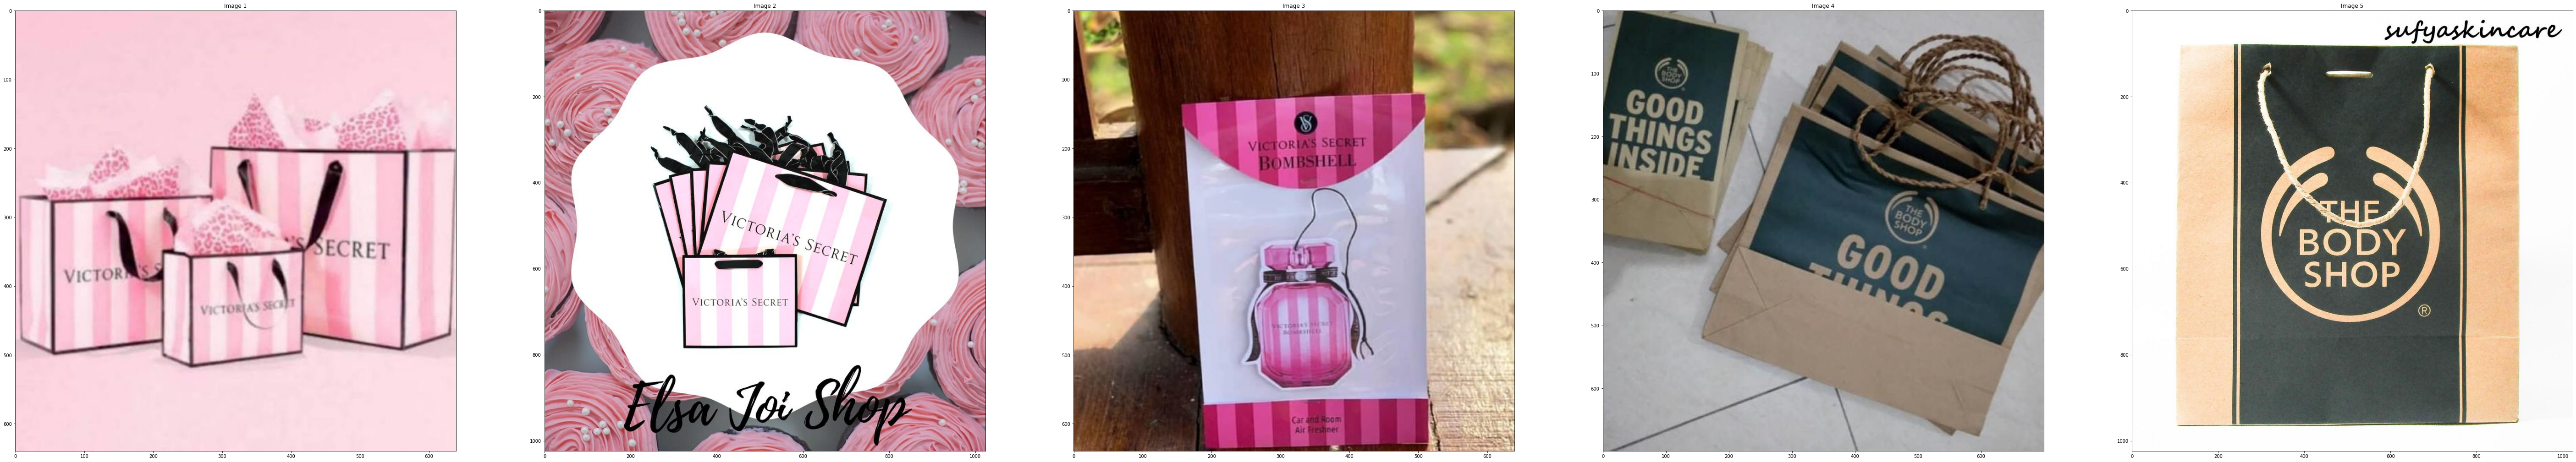

In [8]:
query = "paper bag victoria secret"
search_product(query)